<h1 style="font-size:30px;">Implementing LeNet-5 in Keras</h1>

In this notebook, we will build a model of the LenNet-5 CNN architecture in TensorFlow, and we will use it to perform classification on the MNIST dataset that we used in Module 2. LetNet-5 is a small CNN model that was first introduced in 1998 [LeNet-5](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf). Even though this network is very small, it performs much better than a standard MLP network because CNNs are much more effective at processing image data. This will also be an opportunity for us to add a little more structure to the code that we develop in order to formalize the training process by encapsulating the various steps into functions that allow us to build more modular code.


<img src='https://opencv.org/wp-content/uploads/2022/03/c4_03_LeNet-5_architecture.png' width=1000 align='center'><br/>

# Table of Contents

* [1 System Configuration](#1-System-Configuration)
* [2 Dataset Processing](#2-Dataset-Processing)
* [3 Modeling the LeNet5 Architecture](#3-Modeling-the-LeNet5-Architecture)
* [4 Training Pipeline](#4-Training-Pipeline)
* [5 Training Execution](#5-Training-Execution)
* [6 Model Evaluation](#6-Model-Evaluation)
* [7 Conclusion](#7-Conclusion)

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from dataclasses import dataclass                     # For dataclass decorator      

block_plot = False

# Fix seeds for reproducibility.
SEED_VALUE = 29
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE) 

## 1 System Configuration

In [2]:
def system_config():
    
    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)
    
    if len(gpu_devices) > 0:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
        
        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
        
        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        
        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

system_config()

[]
Using CPU


## 2 Dataset Processing

We will use the MNIST dataset that you are now familiar with.

<img src='https://learnopencv.com/wp-content/uploads/2022/01/c4_02_MNIST_Digits.jpg' width=650 align='center'>


### 2.1 Read the Dataset

In [3]:
def get_data():
    
    mnist_data = tf.keras.datasets.mnist
    
    # Load dataset.
    (X_train_in, y_train_in), (X_test_in, y_test_in) = mnist_data.load_data()
    
    return (X_train_in, y_train_in), (X_test_in, y_test_in)

### 2.2 Data Preprocessing Pipeline


In [4]:
def preprocess_dataset(train_set, test_set, resize_to=None, num_classes=10, seed=3):

    (X_train, y_train) = train_set
    (X_test, y_test) = test_set

    # Split training data into train and validation.
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, 
                                                          y_train,
                                                          shuffle=True,
                                                          stratify=y_train,
                                                          test_size=0.1,
                                                          random_state=seed,
                                                         )

    # Add axis to gray scale - thats the LeNet 50 input default format.
    if len(X_train.shape) != 4:
        X_train = tf.expand_dims(X_train, axis=3)
        X_valid = tf.expand_dims(X_valid, axis=3)
        X_test  = tf.expand_dims(X_test,  axis=3)
     
    # Resize images if requested.
    if resize_to:
        if isinstance(resize_to, int):
            resize_to = (resize_to, resize_to)
        X_train = tf.image.resize(X_train, resize_to)
        X_valid = tf.image.resize(X_valid, resize_to)
        X_test  = tf.image.resize(X_test,  resize_to)

    n_train = X_train.shape[0]
    n_valid = X_valid.shape[0]
    n_test  = X_test.shape[0]

    image_shape = X_train[0].shape
    print('\n')
    print('There are {} training examples'.format(n_train))
    print('There are {} validation examples'.format(n_valid))
    print('There are {} test examples'.format(n_test))
    print('Image data shape is {}'.format(image_shape))
    
    # Confirm no of unique labels present in the dataset matches num_classes - extra error checking.
    assert num_classes == len(
        np.unique(y_train)
    ), "Number of classes present in the dataset does not match specified nuber of classes."
    
    print('There are {} classes'.format(num_classes))
    
    NUM_CLASSES = num_classes
  
    # One-hot encode labels if necessary.
    if len(y_train.shape) != 2:
        y_train = tf.one_hot(y_train, NUM_CLASSES)
        y_valid = tf.one_hot(y_valid, NUM_CLASSES)
        y_test  = tf.one_hot(y_test,  NUM_CLASSES)
    
    print('\nData split:\n')
    print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
    print(f'X_valid: {X_valid.shape}, y_valid: {y_valid.shape}')
    print(f'X_test:  {X_test.shape},  y_test:  {y_test.shape}')

    # Normalize pixel values to the range: [0. - 1.0].
    X_train = X_train / 255.0
    X_valid = X_valid / 255.0
    X_test  = X_test  / 255.0

    print("\nGround truth labels have been one-hot encoded: \n")
    print(np.transpose(y_train[:9]))
    
    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test)

### 2.3 Data Visualization

It's always a good idea to explore the dataset you are using. We have already used the MNIST dataset in Module 1, but it's good to build a small function that can easily display a small portion of the dataset.

In [5]:
# convienience function to visualize samples.
def visualize_samples(X, y):       
    
    plt.figure(figsize=(18, 8))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i], cmap='gray')
        plt.xlabel(y[i])
        plt.axis("off")
        
    plt.suptitle('Dataset Samples', fontsize=18)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show(block=block_plot)
    plt.close()

11490434/11490434 [==============================] - 1s 0us/step


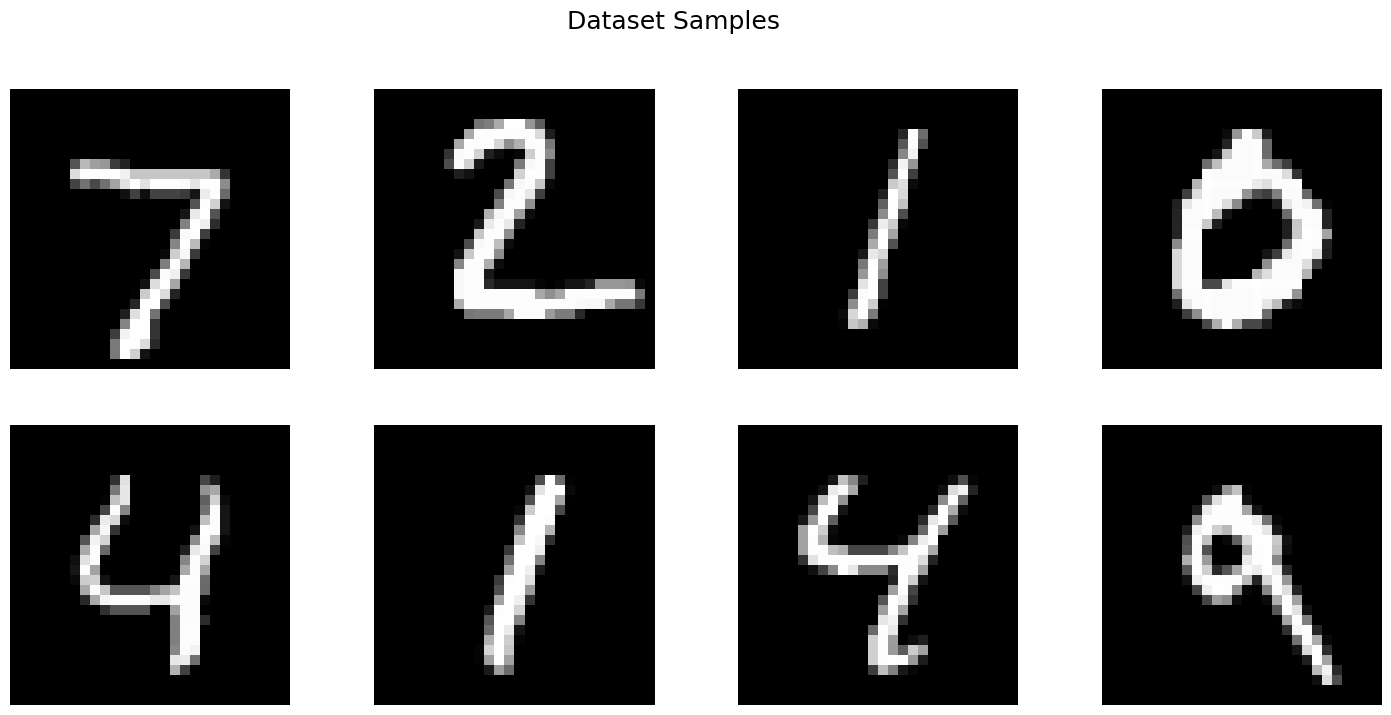

In [6]:
# Download the MNIST dataset.
(X_train_in, y_train_in), (X_test_in, y_test_in) = get_data()

visualize_samples(X_test_in, y_test_in)

### 2.4 Preprocess the Dataset

We can use Python's shorthand notation (`@dataclass`) that was introduced in Python 3.7, to create simple classes for the purpose of configuring dataset and training parameters. This is helpful as a means to encapsulate related data items and helps to keep our code clean and modular.

In [7]:
@dataclass(frozen=True)
class DatasetConfig:
    # Image dimensions 32x32x1 (gray scale) & 10 classes.
    IMG_HEIGHT:  int = 32
    IMG_WIDTH:   int = 32
    CHANNELS:    int = 1
    NUM_CLASSES: int = 10
        
@dataclass(frozen=True)
class TrainingConfig:
    # Hyperparameters.
    BATCH_SIZE:     int   = 32
    EPOCHS:         int   = 21
    LEARNING_RATE:  float = 0.01

data_config = DatasetConfig()
training_config = TrainingConfig()
        
# Preprocess the dataset.
((X_train, y_train), 
 (X_valid, y_valid), 
 (X_test,  y_test)) = preprocess_dataset((X_train_in, y_train_in),
                                        (X_test_in, y_test_in),
                                        resize_to=(data_config.IMG_HEIGHT, data_config.IMG_WIDTH),
                                        num_classes=data_config.NUM_CLASSES,
                                        )



There are 54000 training examples
There are 6000 validation examples
There are 10000 test examples
Image data shape is (32, 32, 1)
There are 10 classes

Data split:

X_train: (54000, 32, 32, 1), y_train: (54000, 10)
X_valid: (6000, 32, 32, 1), y_valid: (6000, 10)
X_test:  (10000, 32, 32, 1),  y_test:  (10000, 10)

Ground truth labels have been one-hot encoded: 

[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]]


## 3 Modeling the LeNet5 Architecture

This network has two convolutional layers and three fully connected layers. The model architecture can be then divided into two parts:


1. **`Body`**: This implements the Convolutional part of the network, which consists of the two convolutional layers. Each convolutional layer is followed by a pooling layer. In classical Machine Learning terms, it also works as a feature extractor.
2. **`Head`**: This implements the fully-connected part of the network. It consists of three fully-connected layers, with the last layer having ten output classes.

### 3.1 Convolutional Layer Function Syntax


```python
tf.keras.layers.Conv2D(
    filters, kernel_size, strides=(1, 1), padding='valid',
    data_format=None, dilation_rate=(1, 1), groups=1, activation=None,
    use_bias=True, kernel_initializer='glorot_uniform',
    bias_initializer='zeros', kernel_regularizer=None,
    bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
    bias_constraint=None, **kwargs)
```

Where,

* **`filters`:** Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
* **`kernel_size`:** An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. It can be a single integer to specify the same value for all spatial dimensions.
* **`strides`:** An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width. It can be a single integer to specify the same value for all spatial dimensions. Specifying any stride value != 1 is incompatible with specifying any dilation_rate value != 1.
* **`padding`:** one of "valid" or "same" (case-insensitive). "valid" means no padding. "same" results in padding with zeros evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input.
* **`activation`:**	Activation function to use. If you don't specify anything, no activation is applied (see keras.activations).
* **`use_bias`:** Boolean, whether the layer uses a bias vector.


The full documentation is available here:  <a target="_blank"  href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D">Conv2D Documentation</a>.

### 3.2 Dense Layer Function Syntax


```python
tf.keras.layers.Dense(
    units, activation=None, use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros', kernel_regularizer=None,
    bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
    bias_constraint=None, **kwargs
)
```

Where,

* **`units`:**	Positive integer, dimensionality of the output space.
* **`activation`:**	Activation function to use. If you don't specify anything, no activation is applied (ie. "linear" activation: a(x) = x).
* **`use_bias`:**	Boolean, whether the layer uses a bias vector.


The full documentation is available here: <a target="_blank"  href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense">Dense Layer Documentation</a>.



### 3.3 LeNet-5 Model using Keras Function API

In this section, we are going to implement the LeNet-5 model in Keras using the functional API. This particualr model is slightly different from the original version which used Average Pooling and Tanh activations. Here, we will use Max Pooling and Relu activations. This function will then be used in the training pipeline described in Section 4.

In [9]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Activation, Conv2D, Dense, Flatten, Input, MaxPool2D

Defining the single convolutional block, unlike other notebooks. This includes:
* Convolutional Layer
* Max Pooling Layer
* Relu Activation
* 

In [10]:
def LeNet5_model(input_shape=(32, 32, 1), num_classes=10, print_summary=True):

    inputs = Input(shape=input_shape)
    
    # BODY (Feature Extractor)
    # -------------------------------------
    # First convolutional Layer + pooling
    # -------------------------------------
    x = Conv2D(6, 5, padding='valid')(inputs)              # input size = (32, 32), output size = (28, 28)
    x = Activation("relu")(x)                              # output size = (28, 28)
    x = MaxPool2D()(x)                                     # output size = (14, 14)

    # -------------------------------------
    # Second convolutional layer + pooling 
    # -------------------------------------
    x = Conv2D(16, 5, padding='valid')(x)                  # input size = (14, 14), output size = (10, 10)
    x = Activation('relu')(x)                              # output size = (10, 10)
    feature_extractor_output = MaxPool2D()(x)              # output size = (5, 5)

    # Flatten.
    flattened = Flatten()(feature_extractor_output)        # 5 * 5 * 16 -> 400

    # HEAD
    # ------------------------- 
    # Fully conneted layers.
    # -------------------------
    x = Dense(120, activation='relu')(flattened)           # 400 -> 120
    x = Dense(84, activation='relu')(x)                    # 120 -> 84
    
    # Softmax output layer.
    headout = Dense(num_classes, activation="softmax")(x)  # 84 -> 10
    
    # Create model.
    model = Model(inputs=inputs, outputs=headout, name='LeNet5')
    
    if print_summary:
        model.summary()
        
    return model

### 3.4 LeNet-5 Model using Keras Sequential API

### <font style="color:rgb(50,120,230)">Coding Exercise</font>

The code cell below is an optional exercise for you to complete. You should be familiar with using the sequential API from previous notebooks. However, this is the first time that convolutional layers have been introduced. After you complete the code below, you can (optionally) use this function instead of the function from the previous section (`LeNet5_model`) in the training pipeline, which is described in the following section. Both functions should produce the same results, and the purpose of this exercise is to demonstrate that you can use the Sequential API or the Functional API to implement models in Keras.

In [11]:
def LeNet5_model_seq(input_shape=(32, 32, 1), num_classes=10, print_summary=True):
    
    # Instantiate the model.
    model = tf.keras.Sequential()
    
    # BODY (Feature Extractor)
    # -------------------------------------
    # First convolutional Layer + pooling
    # -------------------------------------
    model.add(Conv2D(6,5, input_shape=input_shape, 
                     padding='valid', activation='relu'))
    model.add(MaxPool2D())

    # -------------------------------------
    # Second convolutional layer + pooling 
    # -------------------------------------
    model.add(Conv2D(16,5, padding='valid', 
                     input_shape=input_shape, activation='relu' ))
    model.add(MaxPool2D())

    # Flatten.
    model.add(Flatten())

    # HEAD
    # ------------------------- 
    # Fully conneted layers.
    # -------------------------
    model.add(Dense(120, activation='relu'))
    model.add(Dense(120, activation='relu'))

    # Softmax output layer.
    model.add(Dense(num_classes, activation='softmax'))

    # Display the model summary.
    if print_summary:
        model.summary()
        
    return model

## 4 Training Pipeline 

As we have seen thus far in the course, training neural network models typically involves many steps. We often refer to these steps as a "training pipeline." The training pipeline might vary depending on the problem type, the model architecture, and the dataset, but there are generally major components that involve data pre-processing and data splitting, defining the model in TensorFlow/Keras, compiling and fitting the model, among other details related to logging results and saving model checkpoints. All these steps can be gathered in a training pipeline function as shown below. 

### 4.1 Training Pipeline Implementation

In [14]:
def train_model_seq(train_set, print_model_summary=False):

    (X_train, y_train) = train_set

    # Initialize the LeNet Model.
    #model = LeNet5_model(input_shape=(data_config.IMG_HEIGHT, data_config.IMG_WIDTH,data_config.CHANNELS,),
    #                     num_classes=data_config.NUM_CLASSES,
    #                     print_summary=print_model_summary,
    #                    )
    
    # Initialize the LeNet Model (using the Sequentail API)
    model = LeNet5_model_seq(input_shape=(data_config.IMG_HEIGHT, data_config.IMG_WIDTH,data_config.CHANNELS,),
                        num_classes=data_config.NUM_CLASSES,
                       print_summary=print_model_summary,)


    # Compile the model.
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=training_config.LEARNING_RATE),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=["accuracy"],
                 )

    print("\n\n")
    # Train the model.
    results = model.fit(X_train,
                        y_train,
                        epochs=training_config.EPOCHS,
                        batch_size=training_config.BATCH_SIZE,
                        validation_data=(X_valid, y_valid),
                       )

    return model, results

## 5 Training Execution

In [13]:
# Start Training.
model, training_results = train_model(train_set=(X_train, y_train), print_model_summary=True)

Model: "LeNet5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 activation (Activation)     (None, 28, 28, 6)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 activation_1 (Activation)   (None, 10, 10, 16)        0         
                                                            

In [15]:
# Start Training.
model, training_results = train_model_seq(train_set=(X_train, y_train), print_model_summary=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 6)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 400)               0         
                                                                 
 dense_3 (Dense)             (None, 120)               4

Both **Functional** & **Sequential** produces the similar val_accuracy of **0.987** & val_loss of **0.04**.

### 5.1 Plot Training Results

In [16]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)

def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    
    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
        
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
    
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, training_config.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show(block=block_plot)
    plt.close()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


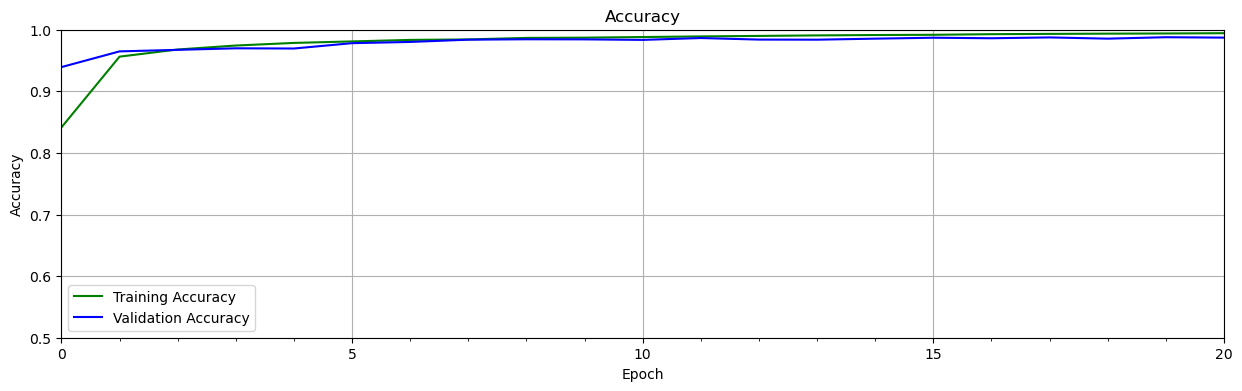

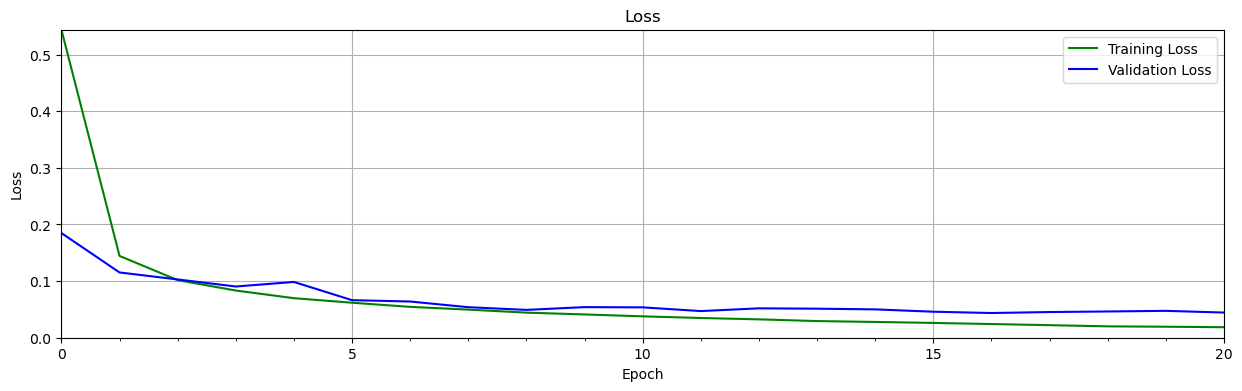

In [17]:
# Print history dictionary keys.
print(training_results.history.keys())

# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]
    
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [.5, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])
 
max_loss = max(max(train_loss), max(valid_loss))

plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, max_loss],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

## 6 Model Evaluation

In [18]:
def evaluate_model(model, *test_set):
    
    X_test, y_test = test_set
        
    # Evaluate model performance on the test set.
    test_results = model.evaluate(X_test, y_test)

    # Select 20 random points from the test set for display.
    random.seed(SEED_VALUE)
    num_rows = 4
    num_cols = 5
    num_data = num_rows*num_cols
    shuffled_index = random.sample(range(y_test.shape[0]), num_data)
    
    X_sampled = tf.gather(X_test, shuffled_index)
    y_sampled = tf.gather(y_test, shuffled_index)

    # Generate predictions on the sampled test set.
    y_pred_sampled = model.predict(X_sampled)
    
    num_matches = 0
    
    # Plot the test images and predicted labels.
    plt.figure(figsize=(18, 12))
    for i in range(num_data):
        plt.subplot(num_rows, num_cols, i + 1)
        pred = np.argmax(y_pred_sampled[i])
        truth = np.argmax(y_sampled[i])
        title = 'True: ' + str(truth) + '; Pred: ' + str(pred)
        title_obj = plt.title(title, fontdict={'fontsize':16})
        
        if pred == truth:
            num_matches += 1
            plt.setp(title_obj, color='g')
        else:
            plt.setp(title_obj, color='r')
        plt.axis("off")
        plt.imshow(X_sampled[i].numpy().squeeze(), cmap="gray")

    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show(block=block_plot)
    
    return test_results

  1/313 [..............................] - ETA: 6s - loss: 2.9256e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 82ms/step


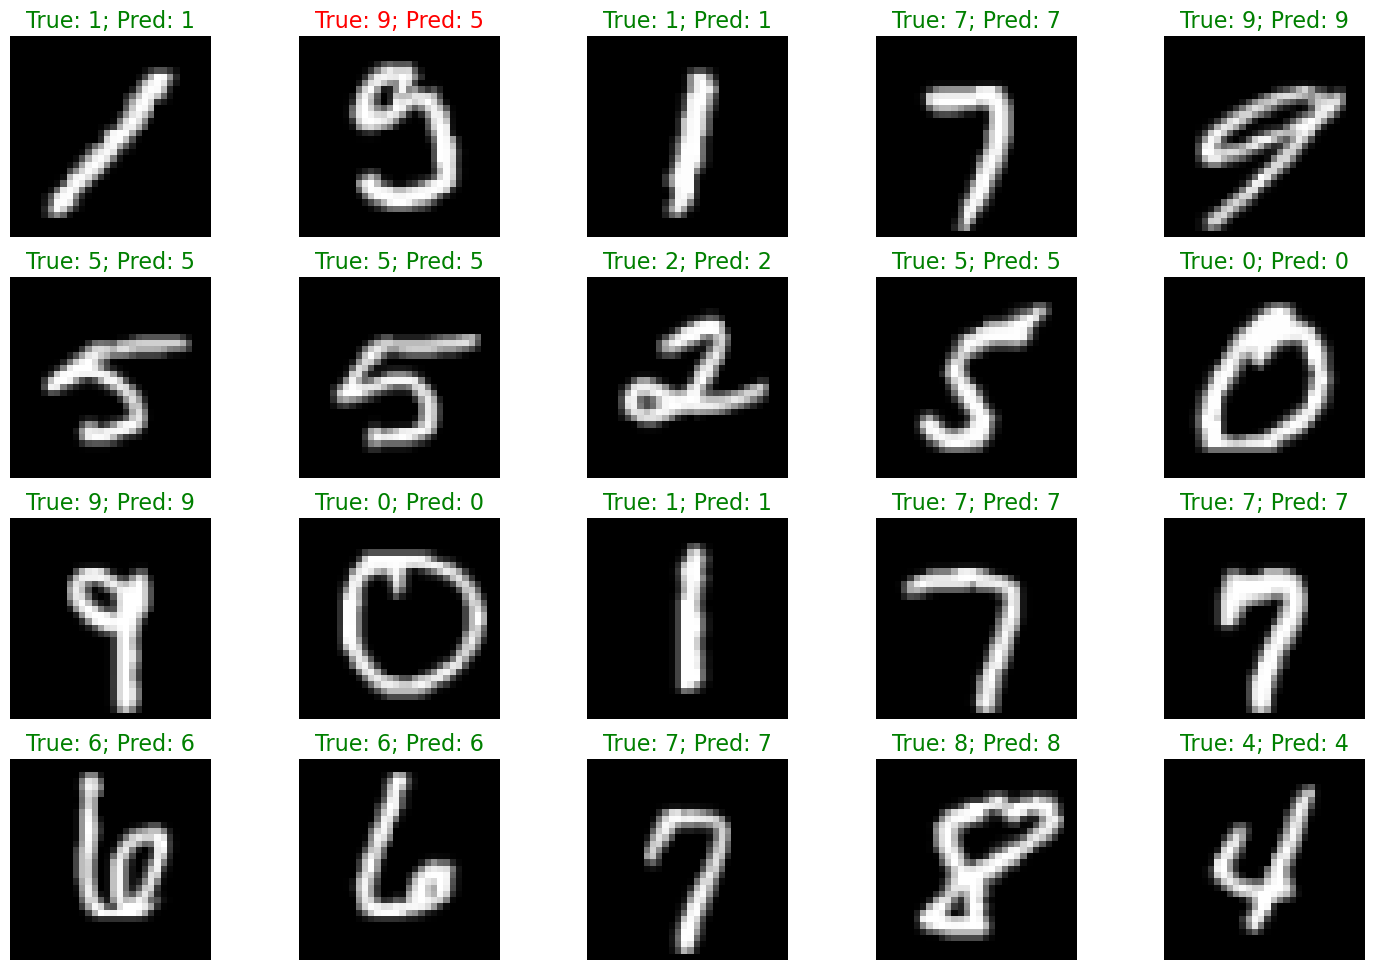

In [19]:
test_set = (X_test, y_test)
test_results = evaluate_model(model, *test_set)

## 7 Conclusion



In this notebook we learned how to implement a straightforward CNN model using Keras, which served as a gentle introduction to the basic building blocks used in modern-day CNN architectures. We also developed more robust and modular code by incorporating more error checking and encapsulating functionality within re-usable functions.